In [1]:
# Basic imports for data handling, preprocessing, model building, evaluation, and visualization
import os
import numpy as np
import pandas as pd

# For image preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For encoding labels and splitting dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# To convert labels into one-hot format for multi-class classification
from tensorflow.keras.utils import to_categorical

# Pre-trained CNN model
from tensorflow.keras.applications import EfficientNetB4

# Model building tools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

# Optimizer for training
from tensorflow.keras.optimizers import Adam

# Callbacks to prevent overfitting and improve training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# L2 regularization to avoid overfitting
from tensorflow.keras.regularizers import l2

# For image loading and basic visualization
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

2025-05-23 14:43:14.667662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748011394.689993      91 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748011394.697242      91 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility. Ensures consistent results every time 
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
TRAIN_IMAGE_DIR = "/kaggle/input/soil-classification/soil_classification-2025/train"
TRAIN_LABELS_PATH = "/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv"

In [4]:
# Load the training labels and display sample entries along with class distribution to understand the dataset

df_train_labels = pd.read_csv(TRAIN_LABELS_PATH)
print("Sample rows from train_labels.csv:")
print(df_train_labels.head())
print(f"\nDataset distribution:")
print(df_train_labels['soil_type'].value_counts())

Sample rows from train_labels.csv:
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil

Dataset distribution:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64


In [5]:
image_paths = []
image_labels = []
missing_count = 0

In [6]:
# Looping through the CSV and collect valid image paths and labels, skipping missing or corrupted files
for idx, row in df_train_labels.iterrows():
    image_id = row['image_id']
    label = row['soil_type']
    image_path = os.path.join(TRAIN_IMAGE_DIR, image_id)

    if os.path.exists(image_path):
        # Verify image can be opened
        try:
            with Image.open(image_path) as img:
                if img.mode in ['RGB', 'L', 'RGBA']:
                    image_paths.append(image_path)
                    image_labels.append(label)
        except Exception as e:
            print(f"Corrupted image: {image_path}")
            missing_count += 1
    else:
        print(f"Warning: {image_path} not found!")
        missing_count += 1

print(f"\n Total valid images: {len(image_paths)}")
print(f" Missing/corrupted images: {missing_count}")


 Total valid images: 1218
 Missing/corrupted images: 0


In [7]:
## Split the dataset into training and validation sets with stratification to preserve class distribution
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

Training samples: 974
Validation samples: 244


In [8]:
# Function to load and preprocess images with resizing, normalization, and error handling 
def preprocess_images_enhanced(paths, img_size=(380, 380)):
    """Enhanced preprocessing with better normalization"""
    images = []
    for path in paths:
        try:
            img = Image.open(path).convert('RGB')
            img = img.resize(img_size, Image.Resampling.LANCZOS)  
            img_array = np.array(img, dtype=np.float32)

            # EfficientNet preprocessing (ImageNet normalization)
            img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            images.append(img_array)
        except Exception as e:
            print(f"Error processing {path}: {e}")
            # Create a black image as fallback
            img_array = np.zeros((img_size[0], img_size[1], 3), dtype=np.float32)
            images.append(img_array)

    return np.array(images)

In [9]:
print("Preprocessing images...")
X_train = preprocess_images_enhanced(train_paths, img_size=(380, 380)) # Consistent image size
X_val = preprocess_images_enhanced(val_paths, img_size=(380, 380))   # Consistent image size

Preprocessing images...


In [10]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (974, 380, 380, 3)
Validation data shape: (244, 380, 380, 3)


In [11]:
# Encode string labels to integers and convert them to one-hot vectors for multi-class classification
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [12]:
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 4
Classes: ['Alluvial soil' 'Black Soil' 'Clay soil' 'Red soil']


In [13]:
# Data augmentation settings to enrich training data with varied transformations for better generalization
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

In [14]:
# Building EfficientNetB4-based model with selective layer freezing and an enhanced classification head using dropout and batch normalization for better generalization
def create_enhanced_model(input_shape=(380, 380, 3), num_classes=num_classes):
    base_model = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze initial layers but allow fine-tuning of top layers
    for layer in base_model.layers[:-70]: # Unfreeze more layers for B4
        layer.trainable = False
    for layer in base_model.layers[-70:]:
        layer.trainable = True

    # Enhanced head architecture
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x) t

    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x) 

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [15]:
model = create_enhanced_model()

I0000 00:00:1748011560.186359      91 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748011560.187029      91 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model has {model.count_params():,} parameters")

Model has 20,050,019 parameters


In [17]:
# Compile the model with Adam optimizer and categorical cross-entropy loss for multi-class classification
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20, 
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10, 
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_soil_classifier_b4.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [18]:
# Create training and validation data generators with batching and optional shuffling for efficient model training
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val_cat,
    batch_size=16,
    shuffle=False
)

In [19]:
# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=val_generator,
    validation_steps=len(X_val) // 16,
    epochs=70, # Increased epochs
    callbacks=callbacks,
    verbose=1
)

Epoch 1/70


I0000 00:00:1748011672.092233     153 service.cc:148] XLA service 0x7c86684b4450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748011672.093954     153 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748011672.093976     153 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748011677.042939     153 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748011683.833210     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011684.014327     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011688.515854     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

17/60 ━━━━━━━━━━━━━━━━━━━━ 22s 523ms/step - accuracy: 0.2655 - loss: 3.9760

E0000 00:00:1748011724.391286     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011724.567504     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011728.611178     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011728.764978     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748011728.965184     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3653 - loss: 3.7517
Epoch 1: val_accuracy improved from -inf to 0.62917, saving model to best_soil_classifier_b4.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.3672 - loss: 3.7471 - val_accuracy: 0.6292 - val_loss: 3.0764 - learning_rate: 1.0000e-04
Epoch 2/70
 1/60 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.6875 - loss: 2.7997
Epoch 2: val_accuracy improved from 0.62917 to 0.63750, saving model to best_soil_classifier_b4.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6875 - loss: 2.7997 - val_accuracy: 0.6375 - val_loss: 3.0737 - learning_rate: 1.0000e-04
Epoch 3/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6094 - loss: 3.0377
Epoch 3: val_accuracy improved from 0.63750 to 0.80000, saving model to best_soil_classifier_b4.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 580ms/step - accuracy: 0.6103 - loss: 3.0354 - val_accuracy: 0.8000 - val_loss: 2.7623 - learning_rate: 1.0000e-04
Epoch 4/70
 1/60 ━━━━━━━━━━━

In [20]:
# Finetuning Phase

# Unfreeze all layers for more aggressive fine-tuning
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999), 
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

finetune_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_soil_classifier_b4_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=val_generator,
    validation_steps=len(X_val) // 16,
    epochs=50, 
    callbacks=finetune_callbacks,
    verbose=1
)



Starting fine-tuning phase...
Epoch 1/50


E0000 00:00:1748013105.215022     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013105.360537     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013105.827427     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013105.973420     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013106.487467     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

21/60 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.7571 - loss: 2.7410 - top_k_categorical_accuracy: 1.0000

E0000 00:00:1748013179.930353     152 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013180.073862     152 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013180.503744     152 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013180.647830     152 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013181.157712     152 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8026 - loss: 2.5907 - top_k_categorical_accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.98750, saving model to best_soil_classifier_b4_finetuned.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.8030 - loss: 2.5894 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9875 - val_loss: 1.9202 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/50
 1/60 ━━━━━━━━━━━━━━━━━━━━ 30s 512ms/step - accuracy: 0.8750 - loss: 2.1889 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.98750
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8750 - loss: 2.1889 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9875 - val_loss: 1.9207 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8722 - loss: 2.3764 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 

In [21]:
val_loss, val_acc, val_top3_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Validation Top-3 Accuracy: {val_top3_acc:.4f}")


Evaluating model...


E0000 00:00:1748013689.762938     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013689.986126     153 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013703.887116     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748013704.081266     154 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



✅ Validation Accuracy: 0.9877
✅ Validation Top-3 Accuracy: 1.0000


In [22]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step 


In [23]:
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.98      0.99       105
   Black Soil       0.98      1.00      0.99        46
    Clay soil       1.00      0.97      0.99        40
     Red soil       0.96      1.00      0.98        53

     accuracy                           0.99       244
    macro avg       0.99      0.99      0.99       244
 weighted avg       0.99      0.99      0.99       244



In [24]:
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.98      0.99       105
   Black Soil       0.98      1.00      0.99        46
    Clay soil       1.00      0.97      0.99        40
     Red soil       0.96      1.00      0.98        53

     accuracy                           0.99       244
    macro avg       0.99      0.99      0.99       244
 weighted avg       0.99      0.99      0.99       244



In [25]:
# Plot training and validation accuracy/loss over epochs, 
# visualize confusion matrix, and display per-class accuracy
def plot_training_history(history, history_finetune=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Combine histories if fine-tuning was done
    if history_finetune:
        train_acc = history.history['accuracy'] + history_finetune.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
        train_loss = history.history['loss'] + history_finetune.history['loss']
        val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

        # Mark where fine-tuning started
        finetune_start = len(history.history['accuracy'])
    else:
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        finetune_start = None

    # Accuracy plot
    axes[0,0].plot(train_acc, label='Training Accuracy')
    axes[0,0].plot(val_acc, label='Validation Accuracy')
    if finetune_start:
        axes[0,0].axvline(x=finetune_start, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss plot
    axes[0,1].plot(train_loss, label='Training Loss')
    axes[0,1].plot(val_loss, label='Validation Loss')
    if finetune_start:
        axes[0,1].axvline(x=finetune_start, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=axes[1,0])
    axes[1,0].set_title('Confusion Matrix')
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')

    # Class-wise accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    axes[1,1].bar(range(len(label_encoder.classes_)), class_acc)
    axes[1,1].set_title('Per-Class Accuracy')
    axes[1,1].set_xlabel('Class')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_xticks(range(len(label_encoder.classes_)))
    axes[1,1].set_xticklabels(label_encoder.classes_, rotation=45)
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


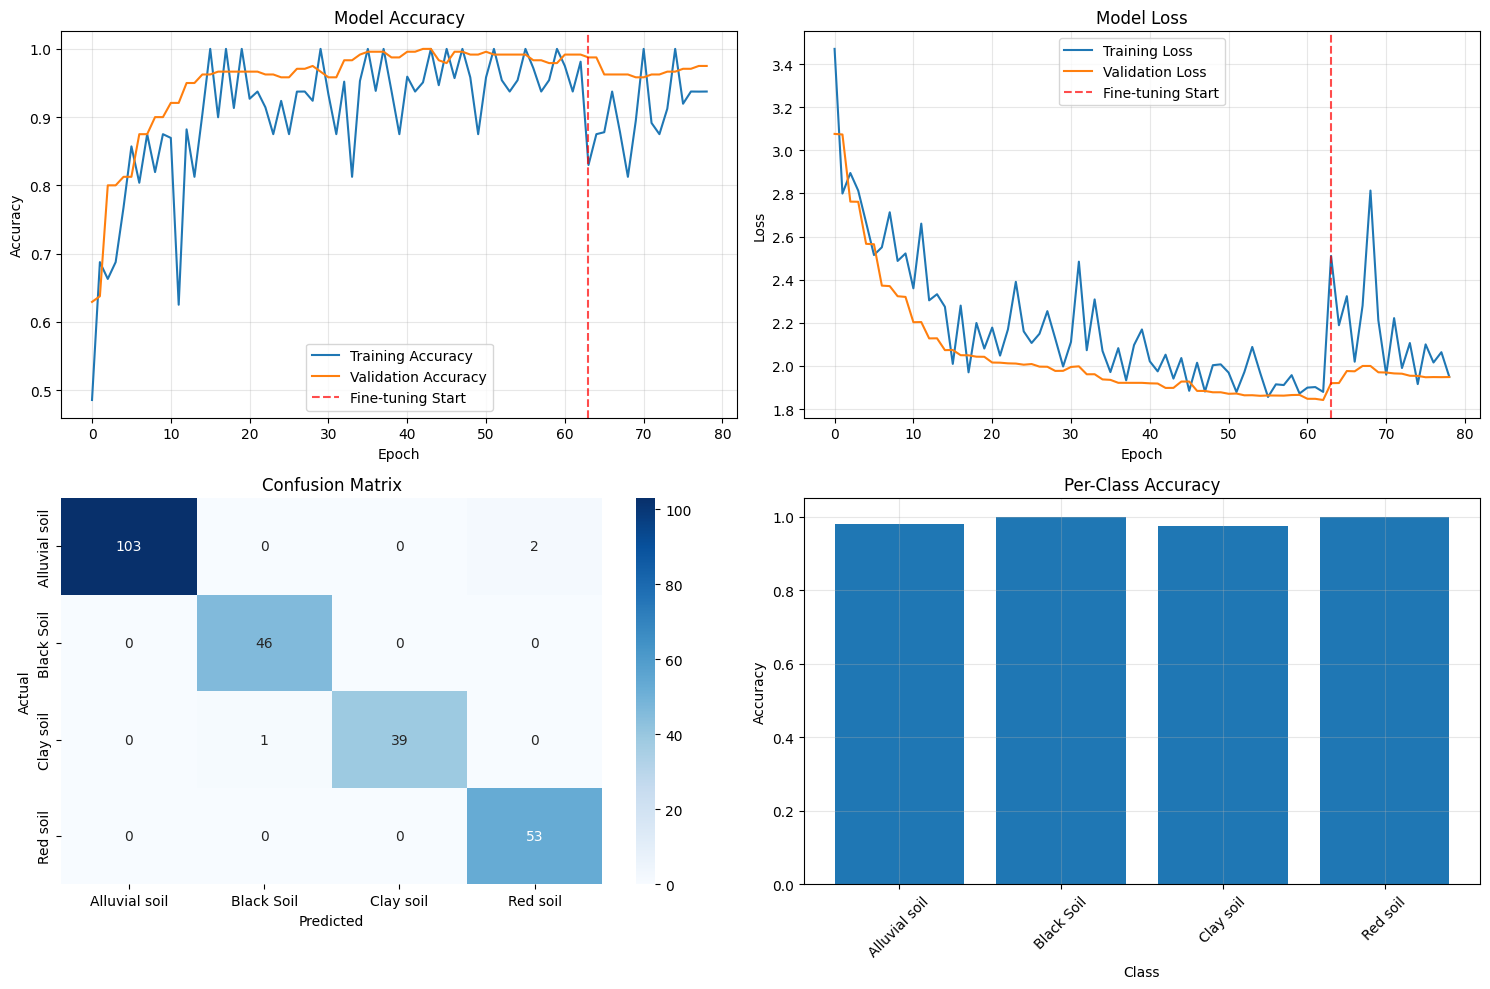

In [26]:
plot_training_history(history, history_finetune)

In [27]:
model.save('soil_classifier_efficientnetb4.h5')
print("\n✅ Enhanced model (EfficientNetB4) saved as 'soil_classifier_efficientnetb4.h5'")



✅ Enhanced model (EfficientNetB4) saved as 'soil_classifier_efficientnetb4.h5'


In [28]:
# Save the fitted label encoder for future use and print final evaluation metrics 
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')
print("✅ Label encoder saved as 'label_encoder.pkl'")

print(f"\n🎯 Final Results:")
print(f"    Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"    Top-3 Accuracy: {val_top3_acc:.4f} ({val_top3_acc*100:.2f}%)")
print(f"    Total Parameters: {model.count_params():,}")

✅ Label encoder saved as 'label_encoder.pkl'

🎯 Final Results:
    Validation Accuracy: 0.9877 (98.77%)
    Top-3 Accuracy: 1.0000 (100.00%)
    Total Parameters: 20,050,019


In [29]:
test_df = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv")
test_image_ids = test_df['image_id'].tolist()

In [30]:
TEST_IMAGE_DIR = "/kaggle/input/soil-classification/soil_classification-2025/test"
test_image_paths = [os.path.join(TEST_IMAGE_DIR, img_id) for img_id in test_image_ids]

In [31]:
#Preprocess the test images
X_test = preprocess_images_enhanced(test_image_paths, img_size=(380, 380))

In [38]:
#Loading the initial with no finetuning to achieve higher accuracy
from tensorflow.keras.models import load_model
print("\nLoading the best model from the initial training phase...")
initial_model = load_model('best_soil_classifier_b4.h5')


Loading the best model from the initial training phase...


In [39]:
#Making predictions using the initial model
initial_y_pred = initial_model.predict(X_val)
initial_y_pred_classes = np.argmax(initial_y_pred, axis=1)
initial_y_true_classes = np.argmax(y_val_cat, axis=1)


Making predictions using the initial model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step 


In [40]:
# Evaluation
initial_accuracy = accuracy_score(initial_y_true_classes, initial_y_pred_classes)
initial_top3_accuracy = top_k_accuracy_score(np.array(y_val), initial_y_pred, k=3) 
print(f"Validation Accuracy (Initial Model): {initial_accuracy:.4f}")
print(f"Validation Top-3 Accuracy (Initial Model): {initial_top3_accuracy:.4f}")


Evaluation of the initial model:
Validation Accuracy (Initial Model): 1.0000
Validation Top-3 Accuracy (Initial Model): 1.0000


In [41]:
print("\nClassification Report (Initial Model):")
print(classification_report(initial_y_true_classes, initial_y_pred_classes,
                            target_names=label_encoder.classes_))


Classification Report (Initial Model):
               precision    recall  f1-score   support

Alluvial soil       1.00      1.00      1.00       105
   Black Soil       1.00      1.00      1.00        46
    Clay soil       1.00      1.00      1.00        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           1.00       244
    macro avg       1.00      1.00      1.00       244
 weighted avg       1.00      1.00      1.00       244




Confusion Matrix (Initial Model):


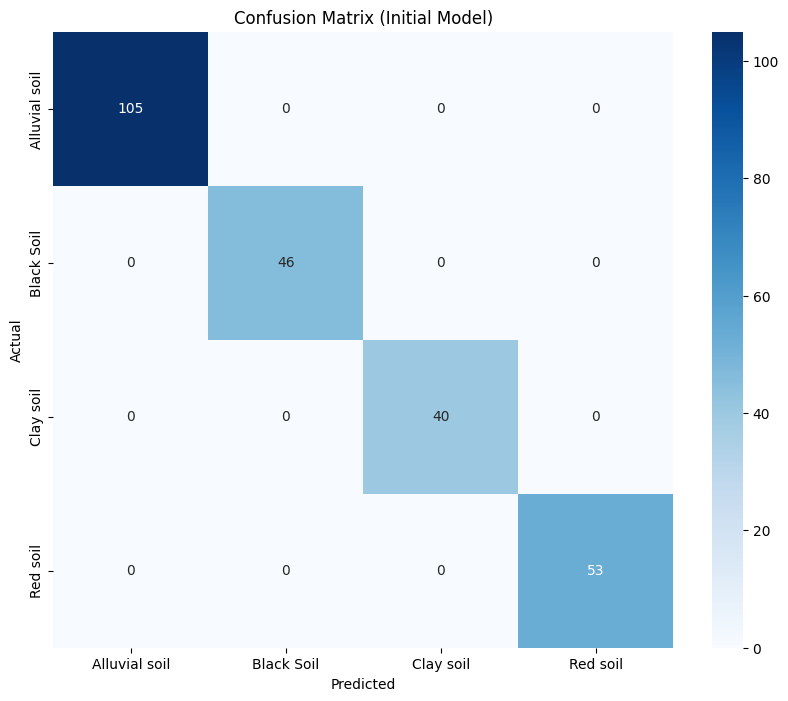

In [42]:
print("\nConfusion Matrix (Initial Model):")
cm_initial = confusion_matrix(initial_y_true_classes, initial_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Initial Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
y_test_pred = initial_model.predict(X_test)

y_test_classes = np.argmax(y_test_pred, axis=1)

predicted_labels = label_encoder.inverse_transform(y_test_classes)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step


In [44]:
submission_df = pd.DataFrame({
    'image_id': test_image_ids,
    'soil_type': predicted_labels
})

submission_df.to_csv('submissions.csv', index=False)